# Task

Select a set $S = { S_1, S_2, …, S_n }$ of sequences of events from the set $E$:
* the size of set E has to be at least 10: $\#{E} \ge 10$,
* the average length of sequences > 5: $avg({len(S_i)}) > 5$,
* $n > 200$. 

For example: $S$ are the sentences from some book (project Gutenberg), events are letters in the sentences - $E$ is the alphabet extended with punctuation marks and space.

Construct a transition matrix of a Markov chain summarizing selected set S. Consider two options: you start counting with
* all entries set to 0
* all entries set to 1
Starting with 1 is beneficial because we won't have zero's.

Define a value $v(S)$ of a sequence $S = e_1,e_2,…,e_k$ as a geometric mean of probabilities of the corresponding transitions

$v(S) = ( p(e_1,e_2) \times p(e_2,e_3) \times p(e_3,e_4) \times … \times p(e_{k-1},e_k) )^{1/(k-1)}$

$v(S)$ is a multiplication of probabilities. A large value of v(S) means S is specific for that Markov chain.

Compute the distribution of values $v(S)$ for all sequences from $S$. Compare it with (a distribution of) values of some other sequences - for example another book in some other language.

# Data

I like books and I liked the idea about books. So, I chose four books for the task:

The primary corpus. It's the book which is used to build the transition matrxi.

1. Wuthering Heights by Emily Bronte [link](http://www.gutenberg.org/ebooks/768). It's in English with some rare and some words.

Three books to compare against the primary corpus:

2. Odes and Epodes by Horace [link](http://www.gutenberg.org/ebooks/9646)

I was interested a bit into comparing an 'old' English with the relatively 'modern' English. For that reason, I also compared the distribution for the book

3. Romeo and Juliet by William Shakespeare [link](http://www.gutenberg.org/ebooks/2261)

and because I took the task as building a classification model I chose one more book in Latin

4. De Bello Gallico by Julius Caesar [link](http://www.gutenberg.org/ebooks/218)

The texts were tokenized into words, all words were converted to the lower case before processing, words with the length less than 2 were dismissed.

# Initialization

In [1]:
sequence_sets = {0: {'name':         'Wuthering Heights by Emily Bronte',
                     'file_name':    'data/768.txt.zip',
                     'start_marker': 'WUTHERING HEIGHTS.+?CHAPTER I',
                     'end_marker':   '\*\*\*END OF THE PROJECT GUTENBERG EBOOK.+?\*\*\*',
                     'lang':         'English'},
                 1: {'name':         'Romeo and Juliet by William Shakespeare',
                     'file_name':    'data/pg2261.txt.zip',
                     'start_marker': 'The Tragedie of Romeo and Juliet.+?Actus Primus. Scoena Prima.',
                     'end_marker':   'FINIS. THE TRAGEDIE OF ROMEO and IVLIET',
                     'lang':         'Old English'},
                 2: {'name':         'Odes and Epodes by Horace',
                     'file_name':    'data/pg9646.txt.zip',
                     'start_marker': 'Q. HORATII FLACCI',
                     'end_marker':   'End of the Project Gutenberg EBook of Odes and Epodes, by Horace',
                     'lang':         'Latin'},
                 3: {'name':         'De Bello Gallico by Julius Caesar',
                     'file_name':    'data/pg218.txt.zip',
                     'start_marker': 'CAESAR\'S COMMENTARIES IN LATIN.+?By Julius Caesar',
                     'end_marker':   'End of Project Gutenberg\'s Cæsar\'s Commentaries',
                     'lang':         'Latin'}}

# dictionary of models built for the sequence sets
models = {}

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging

import sys

import numpy as np
import pandas as pd

pd.set_option('display.max_rows',    100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import statsmodels.api as sm

logger = logging.getLogger('main')

if (logger.hasHandlers()):
    logger.handlers.clear()

logger.addHandler(logging.StreamHandler(sys.stdout))
logger.handlers[-1].setFormatter(logging.Formatter(fmt='%(asctime)s - %(levelname)s - %(message)s', 
                                                   datefmt='%Y-%m-%d %H:%M:%S'))

logger.setLevel(logging.DEBUG)

# Build Models

Importing my own model which describes a model class

In [3]:
import mc_gmean_model

Loading the data and processing it, the result is geometric means for each sequence in the data. Also, I calculate transition matrices for each data set just out of curiosity. N.B. For calculting geometric means only the primary data set' transition matrix is used for all cases.

P.S. The warning message 'divide by zero encountered in log' below happens when calculating geometric means for a sequence with zero probabilities for some transitions. It can be ignored.

In [4]:
# masking function: True - valid sequences, False - not valid sequence
def seq_mask(s):
    return(s.isalpha() and len(s) >= 2)

# transformation of sequence
def seq_transform(s):
    return(s.lower())

for seq_set_no, v in sequence_sets.items():
    
    #if seq_set_no > 0:
    #    continue
        
    print('Processing the set ''%s''' % v['name'])

    models[seq_set_no] = mc_gmean_model.mc_gmean_model()

    # getting sequences from a file
    file_name = v['file_name']
    t = mc_gmean_model.text_file_tokenizer(file_name)
    seqs = t.tokenize(v['start_marker'], v['end_marker'], mask_fn = seq_mask, transform_fn = seq_transform)
    
    models[seq_set_no].transition_matrix(sequences = seqs)
    #models[seq_set_no].compute_seqs()
    models[seq_set_no].compute_seqs(tm = models[0].tm)
    models[seq_set_no].describe()
    
    print()

Processing the set Wuthering Heights by Emily Bronte
2018-06-26 23:57:20 - DEBUG - Read the textual information of the length 681636
2018-06-26 23:57:20 - DEBUG - The length after taking the part between the markers: 661838
The number of sequences: 9025
The minimal length:      2.00
The maximum length:      18.00
The average length:      7.15

Processing the set Romeo and Juliet by William Shakespeare
2018-06-26 23:57:28 - DEBUG - Read the textual information of the length 156143
2018-06-26 23:57:28 - DEBUG - The length after taking the part between the markers: 139770


c:\python36\lib\site-packages\scipy\stats\stats.py:305: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


The number of sequences: 3754
The minimal length:      2.00
The maximum length:      16.00
The average length:      6.16

Processing the set Odes and Epodes by Horace
2018-06-26 23:57:31 - DEBUG - Read the textual information of the length 168845
2018-06-26 23:57:31 - DEBUG - The length after taking the part between the markers: 148761
The number of sequences: 8234
The minimal length:      2.00
The maximum length:      16.00
The average length:      6.87

Processing the set De Bello Gallico by Julius Caesar
2018-06-26 23:57:37 - DEBUG - Read the textual information of the length 169645
2018-06-26 23:57:37 - DEBUG - The length after taking the part between the markers: 149842
The number of sequences: 5659
The minimal length:      2.00
The maximum length:      20.00
The average length:      8.18



Here, I just output the transition matrix to check how it looks like.

In [5]:
models[0].tm

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
a,0.000057,0.021773,0.030551,0.050073,0.000228,0.010317,0.017726,0.002508,0.047280,0.000114,0.016928,0.060532,0.023369,0.241301,0.000057,0.017954,0.000000,0.105161,0.107299,0.160763,0.012141,0.031605,0.012511,0.000712,0.027331,0.001710
b,0.057147,0.009095,0.000000,0.001516,0.373200,0.000000,0.000000,0.000606,0.034106,0.009550,0.000000,0.124451,0.000152,0.000000,0.099742,0.000000,0.000000,0.069425,0.025466,0.008337,0.115204,0.001516,0.000152,0.000000,0.070335,0.000000
c,0.145895,0.000000,0.017241,0.000175,0.166988,0.000000,0.000000,0.148083,0.030719,0.000000,0.056975,0.077017,0.000000,0.000000,0.208122,0.000000,0.002626,0.040959,0.000438,0.068178,0.030807,0.000000,0.000000,0.000000,0.005776,0.000000
d,0.060360,0.000000,0.000133,0.025849,0.307395,0.002398,0.025583,0.000533,0.186676,0.000533,0.000666,0.046902,0.004530,0.007328,0.156429,0.000000,0.000000,0.051566,0.050233,0.000533,0.030247,0.006396,0.001199,0.000000,0.034510,0.000000
e,0.095896,0.001062,0.026048,0.161251,0.042393,0.012888,0.007061,0.003432,0.016518,0.000543,0.003383,0.054220,0.025554,0.112834,0.001531,0.023184,0.002247,0.224779,0.076441,0.045035,0.000346,0.023061,0.007728,0.015555,0.016691,0.000321
f,0.105951,0.000000,0.000000,0.000000,0.117674,0.131350,0.000000,0.000000,0.109558,0.000000,0.000000,0.039525,0.000000,0.000150,0.247220,0.000000,0.000000,0.120679,0.001353,0.062369,0.062218,0.000000,0.000000,0.000000,0.001954,0.000000
g,0.123725,0.000165,0.000000,0.000329,0.190194,0.000000,0.014972,0.235604,0.066469,0.000000,0.000000,0.049687,0.001810,0.019414,0.106120,0.000165,0.000000,0.108424,0.028299,0.007404,0.044587,0.000000,0.000000,0.000000,0.002632,0.000000
h,0.174744,0.000939,0.016828,0.000174,0.511856,0.000522,0.000000,0.000070,0.149885,0.000000,0.000000,0.001738,0.001321,0.000730,0.074821,0.000000,0.000000,0.011195,0.002121,0.033273,0.010987,0.000000,0.000278,0.000000,0.008518,0.000000
i,0.007225,0.006119,0.026851,0.046965,0.037071,0.037234,0.030106,0.000260,0.000683,0.000000,0.007356,0.051587,0.057055,0.316225,0.043255,0.005175,0.000098,0.036550,0.136404,0.129373,0.000456,0.020570,0.000033,0.002083,0.000000,0.001269
j,0.061338,0.000000,0.000000,0.000000,0.206320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.436803,0.000000,0.000000,0.000000,0.000000,0.000000,0.295539,0.000000,0.000000,0.000000,0.000000,0.000000


Printing sequences with the largest values of geometric means (in the descending order) for all four books.

In [6]:
models[0].seqs.sort_values('prob_gmean', ascending = False).head(10)

,count,length,prob_gmean
he,2050,2,0.511856
the,4530,3,0.455113
th,20,2,0.404661
be,723,2,0.373200
you,1723,3,0.370706
ther,3,4,0.359748
there,296,5,0.356405
here,127,4,0.341634
her,1543,3,0.339197
me,1058,2,0.331759


In [7]:
models[1].seqs.sort_values('prob_gmean', ascending = False).head(10)

,count,length,prob_gmean
he,119,2,0.511856
the,658,3,0.455113
th,3,2,0.404661
be,211,2,0.373200
you,289,3,0.370706
there,66,5,0.356405
re,2,2,0.346561
here,74,4,0.341634
her,157,3,0.339197
me,264,2,0.331759


In [8]:
models[2].seqs.sort_values('prob_gmean', ascending = False).head(10)

,count,length,prob_gmean
ver,2,3,0.404415
vere,2,4,0.384130
me,63,2,0.331759
in,157,2,0.316225
de,13,2,0.307395
heredi,1,6,0.260528
indi,1,4,0.246003
condere,1,7,0.244140
findere,1,7,0.243651
an,17,2,0.241301


In [9]:
models[3].seqs.sort_values('prob_gmean', ascending = False).head(10)

,count,length,prob_gmean
re,31,2,0.346561
in,508,2,0.316225
de,82,2,0.307395
inde,9,4,0.290499
vereri,2,6,0.268369
veri,1,4,0.261442
gerere,4,6,0.258496
vero,12,4,0.256640
edere,1,5,0.249278
an,5,2,0.241301


# Graph Visualization

Below, it's an effort to visualize the transition matrix for the primary set.

Name: Graph from pandas adjacency matrix
Type: Graph
Number of nodes: 26
Number of edges: 262
Average degree:  20.1538


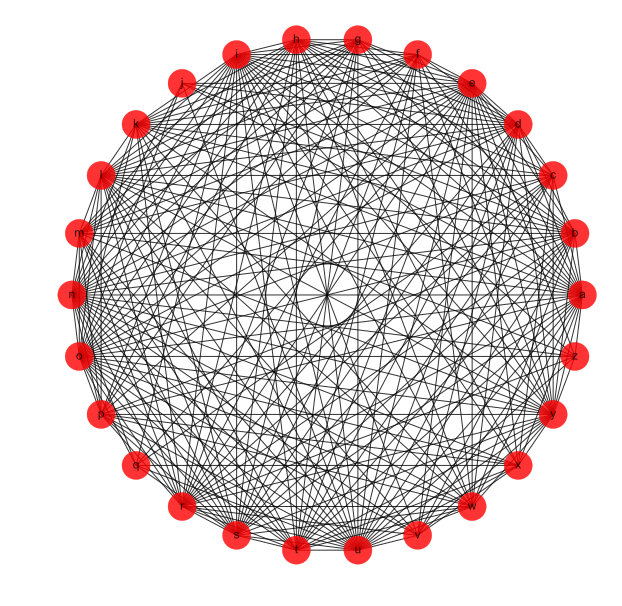

In [10]:
import networkx as nx

G = nx.from_pandas_adjacency(models[0].tm)
G.name = 'Graph from pandas adjacency matrix'
print(nx.info(G))

plt.figure(figsize=(8, 8))
nx.draw_shell(G, with_labels = True, node_size = 800, alpha = 0.8, arrows = True)

# Compare Distributions

## Visualization of Transition Matrices

 Out of curiosity, I visualize the transition matrices for each data set. It's interesting to note that patterns for English and Latin languages seem to differ indeed.

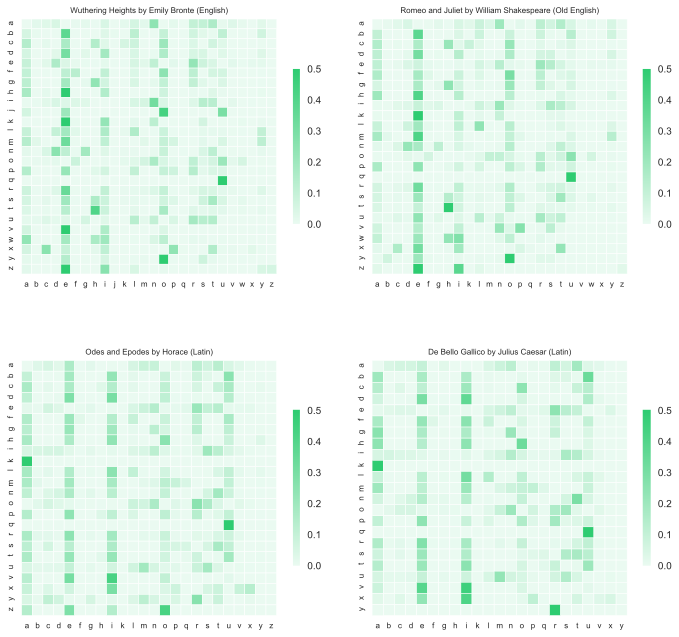

In [15]:
# plot correlation matrix
plt.style.use('seaborn-white')

fig, axs = plt.subplots(figsize=(12, 12), nrows = 2, ncols = 2)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

axs_flatten = axs.flatten()

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

cmap = sns.light_palette("#2ecc71", as_cmap=True)

for model_no, model in models.items():
    
    plt.sca(axs_flatten[model_no])
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(model.tm, 
                # annot = True, annot_kws={"size": 9}, fmt = '.2f',
                cmap=cmap, vmin = 0, vmax= 0.5, # center=0.5,
                square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, ax = axs_flatten[model_no])
    axs_flatten[model_no].set_title('%s (%s)' % (sequence_sets[model_no]['name'], sequence_sets[model_no]['lang']), size = 8)
    
    plt.xticks(np.arange(0, len(model.tm.columns)) + 0.5, model.tm.columns, size = 8)  
    plt.yticks(np.arange(0, len(model.tm.index)) + 0.5,   model.tm.index,   size = 8)

plt.show()

plt.style.use('seaborn')

## Boxplot of Geometric Means Distributions

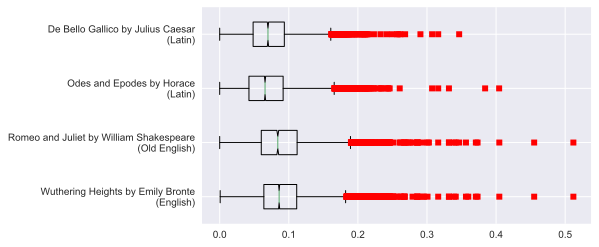

In [12]:
fig, axs = plt.subplots(figsize = (7, 4), ncols=1)

data = []

for model_no, model in models.items():
    data.append(model.seqs['prob_gmean'].values)

p = plt.boxplot(data, model_no, 'rs', 0)

ax = axs.set_yticklabels(['%s\n(%s)' % (v['name'], v['lang']) for k,v in sequence_sets.items()], size = 10)

## Kernel Density Estimation of Geometric Means Distributions

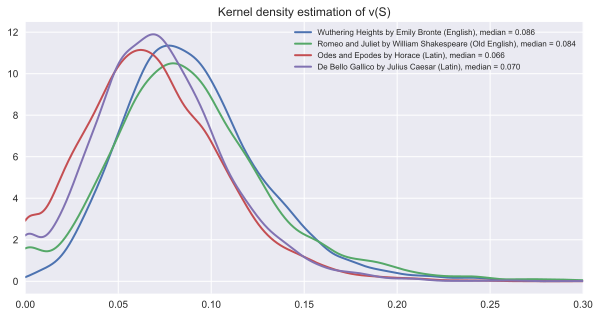

In [13]:
fig, axs = plt.subplots(figsize = (10, 5), ncols=1)

################################################################################
# draw kernel distribuion estimation of v(S)
################################################################################

# plt.sca(axs[1])

for model_no, model in models.items():
    
    median = np.median(model.seqs['prob_gmean'])
    
    kde = sm.nonparametric.KDEUnivariate(model.seqs['prob_gmean'])
    
    # kde.fit(kernel = 'epa', fft = False)
    kde.fit() # gaussian kernel with fft
    
    plt.plot(kde.support, kde.density, lw = 2, 
             label = '%s (%s), median = %.3f' % (sequence_sets[model_no]['name'], sequence_sets[model_no]['lang'], median))

plt.xlim(0, 0.3)    
    
plt.title('Kernel density estimation of v(S)')
plt.legend(fontsize = 8)

plt.show()

# Findings

- The distributions differ for different languages, in the most simplistic case of comparision they have medians in different intervals, their IQR invervals are different.
- The model proposed for the task can be used as a classifier for sets.

Ideas about further steps

- Add a quantitave metric (distance) of how each set far from each other.
- Try the model with different minimums for the word length.
- Run cross-validation to estimate ROC.
- Add support of the extended Latin alphabet to support most of languages based on it like French, Italian etc.

# References
1. [The projects' descriptions on Vlado's site](http://vladowiki.fmf.uni-lj.si/doku.php?id=ru:hse:snet:stu)